## Script's Goals

This script is used to classify the pre-processed transcriptomic data into 3 classes : Healthy, RA, or SLE. The input file is an anndata object.

 ## Import packages

In [14]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

import shap

import gseapy as gp

In [2]:
print(tf.__version__)

2.17.0


## Define Function

In [3]:
def prepare_CNN(y_train, y_test):
    # function to transform the labels in codes
    
    # Conversion of the series in type 'category'
    if y_train.dtype != 'category':
        y_train = y_train.astype('category')
    if y_test.dtype != 'category':
        y_test = y_test.astype('category')
    
    
    # Conversion of category in codes
    y_train_codes = y_train.cat.codes
    y_test_codes = y_test.cat.codes

    # Use of tf.one_hot to convert in one hot encoding
    y_train_one_hot = tf.one_hot(y_train_codes, depth=len(y_train.cat.categories), dtype=tf.float32)
    y_test_one_hot = tf.one_hot(y_test_codes, depth=len(y_test.cat.categories), dtype=tf.float32)

    # Conversion in numpy table
    y_train_np = y_train_one_hot.numpy()
    y_test_np = y_test_one_hot.numpy()

    return y_train_np, y_test_np

In [4]:
def create_model(optimizer, dropout_rate, neurons):
    # function to define the architechture of the neural network
    
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
def prepare_shap(adata):
    # function to prepare a small dataset containing samples from each health_status in the same proportion, to then determined
    # the genes that are importants for the classification
    adata_h = adata[adata.obs["status"] == "healthy"][:30]
    adata_ra = adata[adata.obs["status"] == "ra"][:30]
    adata_sle = adata[adata.obs["status"] == "sle"][:30]
    
    list_adata = [adata_h,adata_ra,adata_sle]
    
    adata_shap = ad.concat(list_adata)
    
    return adata_shap
    

In [6]:
def perform_shap(adata):
    # function to perform the shap analysis to get the most importants genes for the classification of health_status

    
    X_shap = adata.X
    sample_data = X_shap.toarray() if hasattr(X_shap, "toarray") else X_shap
    
    # get the gene names
    gene_names = adata.var_names.tolist()


    # Create the SHAP explainer for the Keras model
    explainer = shap.DeepExplainer(model, sample_data)

    # Calculate SHAP values for a subset of data
    shap_values = explainer.shap_values(sample_data)
    
    return shap_values, sample_data, gene_names


In [32]:
def give_importance(shap_values, i):
    shap_importance = np.abs(shap_values[i].T).mean(axis=0)

    # Créer un DataFrame pour faciliter la manipulation (en supposant que gene_names est la liste des noms de gènes)
    shap_df = pd.DataFrame({
        'gene': gene_names,
        'importance': shap_importance
    })

    # Trier les gènes par importance décroissante et récupérer les 10 premiers
    top_10_genes = shap_df.sort_values(by='importance', ascending=False).head(10)['gene'].tolist()

    # Afficher ou utiliser la liste des 10 gènes les plus importants
    return top_10_genes

## Load the data

In [7]:
adata = ad.read_h5ad("/home/mc202900/outputs/Dataset_PP_500")

## Split the anndata object into a train object and a test object

In [8]:
# Train object
adata_train = adata[adata.obs["role"] == "train"].copy()

#Test object
adata_test = adata[adata.obs["role"] == "test"].copy()


# Perform the Machine Learning

## Random Forest

In [9]:
##Perform a RF algorithm on the expression dataset

labels_train = adata_train.obs["status"]  # Extraction of health status
labels_test = adata_test.obs["status"]  # Extraction of health status

# Extract expression values
X_train = adata_train.X
X_test = adata_test.X

# Train the classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, labels_train)

# Predict on the test dataset
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Get probabilities for each class

# Stock predictions in adata_test
adata_test.obs['pred'] = y_pred

# Display the classification report
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       100
          ra       0.58      1.00      0.73       330
         sle       1.00      0.48      0.65       465

    accuracy                           0.73       895
   macro avg       0.86      0.83      0.79       895
weighted avg       0.84      0.73      0.72       895



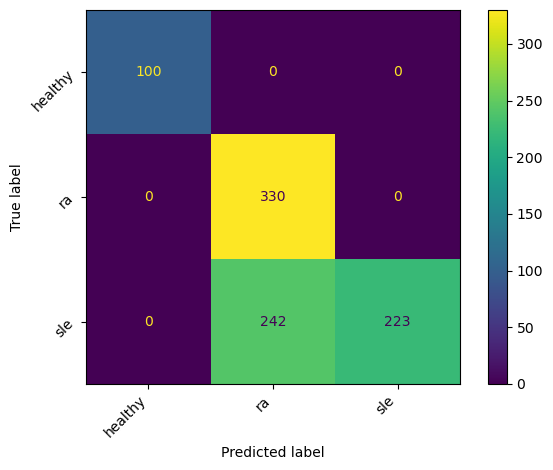

In [10]:
cm = confusion_matrix(labels_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Adjust the rotation of the x-axis labels and y-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

Healthy status is perfectly predicted. RA and SLE are predicted with a good f1-score (0.73 and 0.79, respectively). The model is overall performant (accuracy = 0.73), but it often predicts SLE samples as RA samples (242 mistakes).

Gene HBB importance: 0.024958609447494888
Gene IFI27 importance: 0.0185738009831277
Gene CD177 importance: 0.017872824468206313
Gene TPX2 importance: 0.014315772258782188
Gene IFI44L importance: 0.013912648191730582
Gene HBA2 importance: 0.012791587651189323
Gene TNNI2 importance: 0.010693534928918448
Gene APOD importance: 0.010447942690048794
Gene MATK importance: 0.010424459915276718
Gene IFI44 importance: 0.009091352859911533


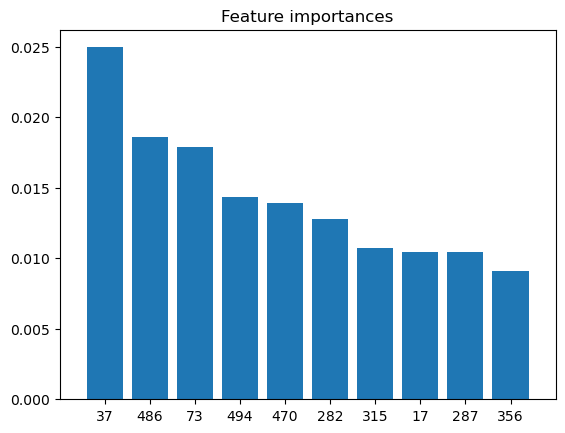

In [11]:
# Observe the most important features of the model

importances = model.feature_importances_

# get genes names

gene_names = adata.var_names.tolist()

# Display the 10 most important features
indices = np.argsort(importances)[::-1]
for i in range(10):
    print(f"Gene {gene_names[indices[i]]} importance: {importances[indices[i]]}")

plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])
plt.xlim([-1, 10])
plt.show()

In [12]:
# List of the 10 most important genes
important_genes = [gene_names[indices[i]] for i in range(10)]

# Enrichment analysis to find associated pathways

enrichment_results = gp.enrichr(gene_list=important_genes,
                                gene_sets="KEGG_2016", 
                                organism='Human',     
                                outdir=None)            

# Display results
print(enrichment_results.results.head(10))  # Affiche les 10 pathways les plus significatifs

    Gene_set                                               Term Overlap  \
0  KEGG_2016      African trypanosomiasis Homo sapiens hsa05143    2/35   
1  KEGG_2016                      Malaria Homo sapiens hsa05144    2/49   
2  KEGG_2016  Neurotrophin signaling pathway Homo sapiens hs...   1/120   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.000133          0.000392            0                     0  151.189394   
1  0.000261          0.000392            0                     0  106.079787   
2  0.058418          0.058418            0                     0   18.553688   

   Combined Score     Genes  
0     1349.727435  HBB;HBA2  
1      875.138256  HBB;HBA2  
2       52.694849      MATK  


Only 3 pathways detected. HBB and HBA2 have 2 pathways in common. But the name of the pathways are not really relevants.

In [13]:
# Enrichment analysis for GO term : Biological Process

enrichment_results = gp.enrichr(gene_list=important_genes,
                                gene_sets='GO_Biological_Process_2018', 
                                organism='Human',
                                outdir=None)

# Display results
print(enrichment_results.results[['Term', 'Adjusted P-value', 'Genes']].head(10))

                                                Term  Adjusted P-value  \
0   response to reactive oxygen species (GO:0000302)          0.035443   
1  negative regulation of lymphocyte migration (G...          0.035443   
2              neutrophil extravasation (GO:0072672)          0.035443   
3                      oxygen transport (GO:0015671)          0.035443   
4  regulation of monocyte chemotactic protein-1 p...          0.035443   
5                     axon regeneration (GO:0031103)          0.035443   
6                 granulocyte migration (GO:0097530)          0.035443   
7             cell junction maintenance (GO:0034331)          0.035443   
8  positive regulation of myeloid leukocyte media...          0.035443   
9  negative regulation of cytokine production inv...          0.035443   

      Genes  
0  HBB;APOD  
1      APOD  
2     CD177  
3       HBB  
4      APOD  
5      APOD  
6     CD177  
7     CD177  
8     CD177  
9      APOD  


Only HBB and APOD have BP in common. There is a lot of genes which have a BP linked to inflammatory/ immune response (e.g. GO term with lymphocyte, neutrophil, monocyte...). This may make sense to identify RA and SLE diseases.

## Neural Network

In [21]:
model = create_model(optimizer='rmsprop', dropout_rate=0.5, neurons=32)

/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
labels_train = adata_train.obs["status"]  # Extraction of health status
labels_test = adata_test.obs["status"]  # Extraction of health status

print(type(labels_train[0]))

y_train, y_test = prepare_CNN(labels_train, labels_test) # encode the labels

# Extract expression values
X_train = adata_train.X
X_test = adata_test.X

<class 'str'>


/tmp/ipykernel_781945/3328365967.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(type(labels_train[0]))


In [23]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4665 - loss: 1.0317 - val_accuracy: 0.5598 - val_loss: 0.8220
Epoch 2/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6521 - loss: 0.6955 - val_accuracy: 0.7084 - val_loss: 0.7104
Epoch 3/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.5367 - val_accuracy: 0.7777 - val_loss: 0.5409
Epoch 4/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8164 - loss: 0.4317 - val_accuracy: 0.7687 - val_loss: 0.5903
Epoch 5/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8413 - loss: 0.3894 - val_accuracy: 0.7665 - val_loss: 0.6038
Epoch 6/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.3443 - val_accuracy: 0.7922 - val_loss: 0.5278
Epoch 7/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.3148 - val_accuracy: 0.8078 - val_loss: 0.4817
Epoch 8/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 - loss: 0.2784 - val_acc

In [24]:
# Evaluate the performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

Test Accuracy: 0.8492
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [25]:
target_names = ['healthy', 'ra', 'sle']
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00       100
          ra       0.71      1.00      0.83       330
         sle       1.00      0.71      0.83       465

    accuracy                           0.85       895
   macro avg       0.90      0.90      0.89       895
weighted avg       0.89      0.85      0.85       895



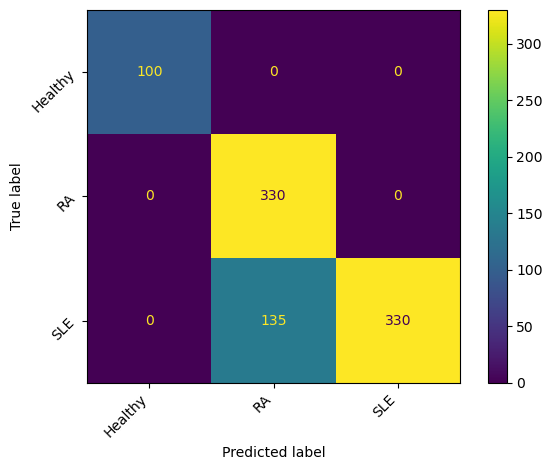

In [26]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "RA", "SLE"])
disp.plot()

# Adjust the rotation of the x-axis labels and y-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

Healthy status is perfectly predicted. RA and SLE are predicted with a good f1-score (0.83 for both). The model is overall performant (accuracy = 0.85) and better than the RF model, but it also often predicts SLE samples as RA samples (130 mistakes).

### Visualize the features importances

In [27]:
# Prepare data
adata_shap = prepare_shap(adata)
# Perform the shap method
shap_values, sample_data, gene_names = perform_shap(adata_shap)
shap_values = shap_values.T

/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/mc202900/.conda/envs/my_env01/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_16. Received: the structure of inputs=['*']
  warnings.warn(


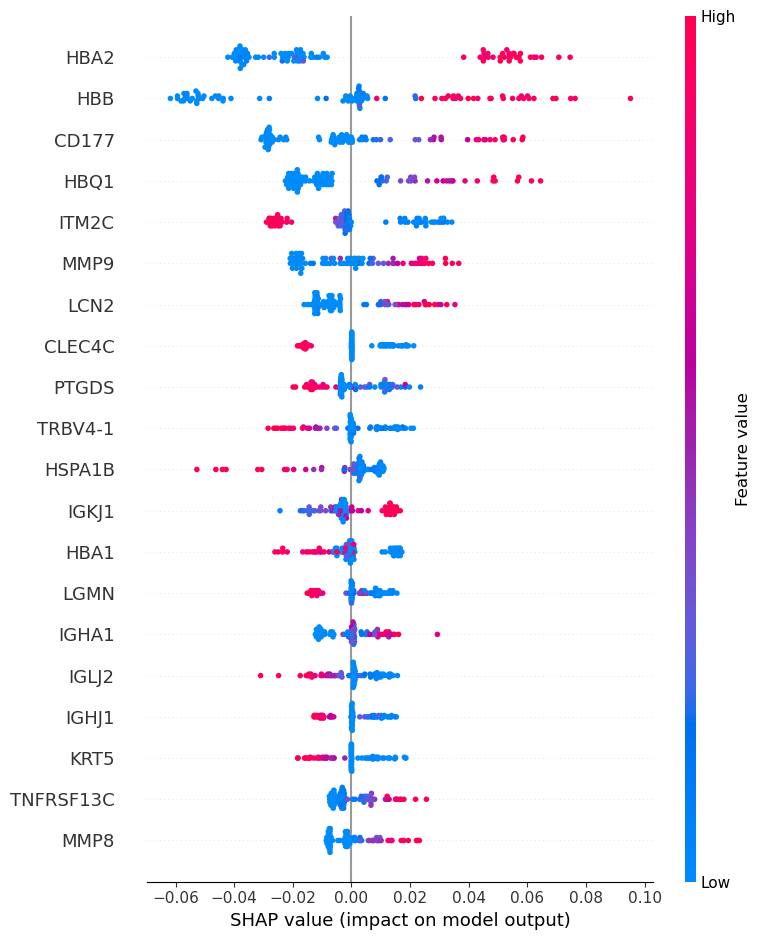

In [28]:
 # Visualization for a specific class (e.g., class Healthy)
shap.summary_plot(shap_values[0].T, sample_data, feature_names=gene_names)

In [34]:
list_0 = give_importance(shap_values, 0)
print(list_0)

['HBA2', 'HBB', 'CD177', 'HBQ1', 'ITM2C', 'MMP9', 'LCN2', 'CLEC4C', 'PTGDS', 'TRBV4-1']


In [37]:
# Enrichment analysis for GO term : Biological Process

enrichment_results = gp.enrichr(gene_list=list_0,
                                gene_sets='GO_Biological_Process_2018', 
                                organism='Human',
                                outdir=None)

# Display results
print(enrichment_results.results[['Term', 'Adjusted P-value', 'Genes']].head(10))

                                                Term  Adjusted P-value  \
0              neutrophil degranulation (GO:0043312)          0.000078   
1  neutrophil activation involved in immune respo...          0.000078   
2          neutrophil mediated immunity (GO:0002446)          0.000078   
3   response to reactive oxygen species (GO:0000302)          0.011960   
4  positive regulation of receptor binding (GO:19...          0.029108   
5              neutrophil extravasation (GO:0072672)          0.029108   
6  positive regulation of keratinocyte migration ...          0.029108   
7  negative regulation of glycoprotein biosynthet...          0.029108   
8                      oxygen transport (GO:0015671)          0.029108   
9                 granulocyte migration (GO:0097530)          0.029108   

                        Genes  
0  CLEC4C;LCN2;HBB;MMP9;CD177  
1  CLEC4C;LCN2;HBB;MMP9;CD177  
2  CLEC4C;LCN2;HBB;MMP9;CD177  
3                    HBB;MMP9  
4                        

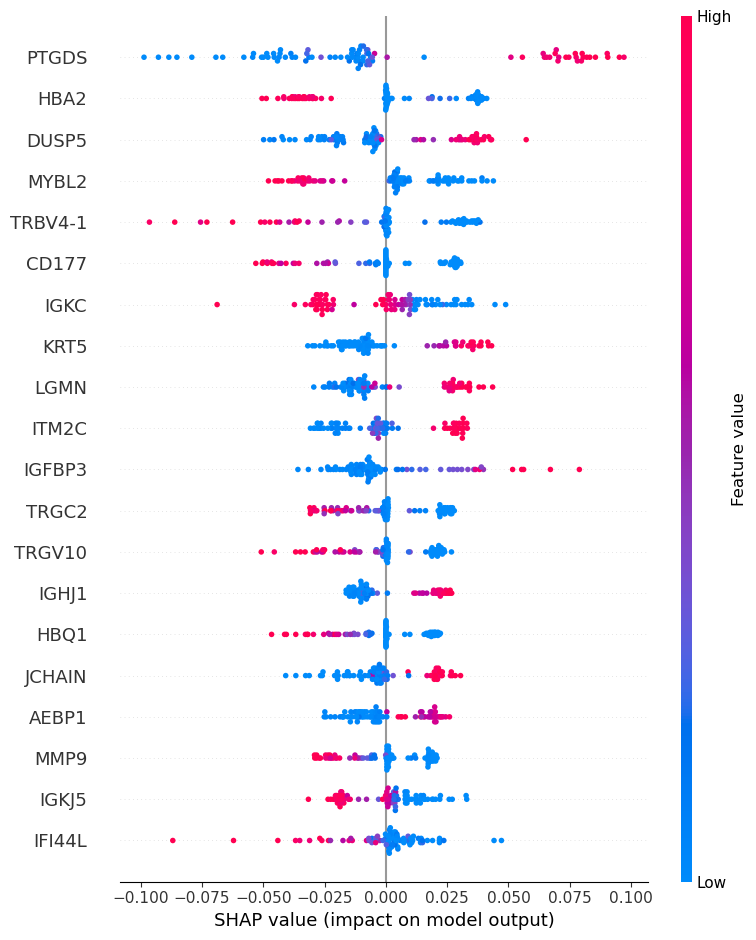

In [29]:
 # Visualization for a specific class (e.g., class RA)
shap.summary_plot(shap_values[1].T, sample_data, feature_names=gene_names)

In [35]:
list_1 = give_importance(shap_values, 1)
print(list_1)

['PTGDS', 'HBA2', 'DUSP5', 'MYBL2', 'TRBV4-1', 'CD177', 'IGKC', 'KRT5', 'LGMN', 'ITM2C']


In [40]:
# Enrichment analysis for GO term : Biological Process

enrichment_results = gp.enrichr(gene_list=list_1,
                                gene_sets='GO_Biological_Process_2018', 
                                organism='Human',
                                outdir=None)

# Display results
print(enrichment_results.results[['Term', 'Adjusted P-value', 'Genes']].head(10))

                                                Term  Adjusted P-value  Genes
0              neutrophil extravasation (GO:0072672)          0.047278  CD177
1  negative regulation of glycoprotein biosynthet...          0.047278  ITM2C
2                 granulocyte migration (GO:0097530)          0.047278  CD177
3             cell junction maintenance (GO:0034331)          0.047278  CD177
4  positive regulation of myeloid leukocyte media...          0.047278  CD177
5  regulation of amyloid precursor protein biosyn...          0.047278  ITM2C
6        cell-cell junction maintenance (GO:0045217)          0.047278  CD177
7                cyclooxygenase pathway (GO:0019371)          0.047278  PTGDS
8  positive regulation of superoxide anion genera...          0.047278  CD177
9                hemidesmosome assembly (GO:0031581)          0.047278   KRT5


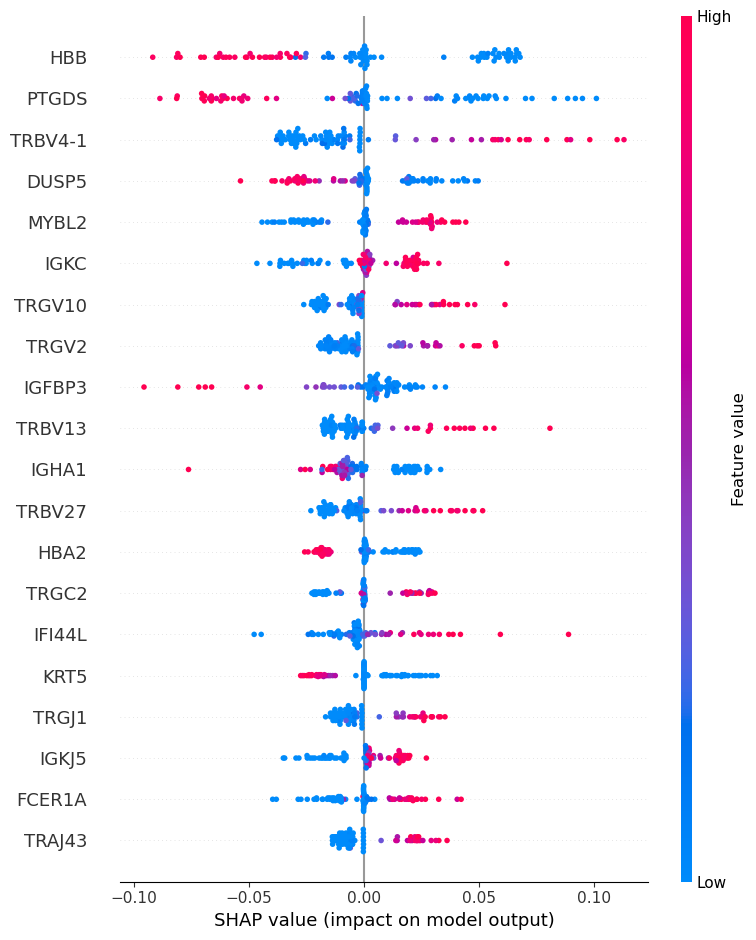

In [30]:
 # Visualization for a specific class (e.g., class SLE)
shap.summary_plot(shap_values[2].T, sample_data, feature_names=gene_names)

In [36]:
list_2 = give_importance(shap_values, 2)
print(list_2)

['HBB', 'PTGDS', 'TRBV4-1', 'DUSP5', 'MYBL2', 'IGKC', 'TRGV10', 'TRGV2', 'IGFBP3', 'TRBV13']


In [39]:
# Enrichment analysis for GO term : Biological Process

enrichment_results = gp.enrichr(gene_list=list_2,
                                gene_sets='GO_Biological_Process_2018', 
                                organism='Human',
                                outdir=None)

# Display results
print(enrichment_results.results[['Term', 'Adjusted P-value', 'Genes']].head(10))

                                                Term  Adjusted P-value  \
0                      oxygen transport (GO:0015671)          0.064552   
1         receptor-mediated endocytosis (GO:0006898)          0.064552   
2                         gas transport (GO:0015669)          0.064552   
3                cyclooxygenase pathway (GO:0019371)          0.064552   
4       prostanoid biosynthetic process (GO:0046457)          0.064552   
5                      renal absorption (GO:0070293)          0.064552   
6  positive regulation of myoblast differentiatio...          0.064552   
7   hydrogen peroxide catabolic process (GO:0042744)          0.064552   
8  negative regulation of smooth muscle cell migr...          0.064552   
9                           endocytosis (GO:0006897)          0.064552   

      Genes  
0       HBB  
1  IGKC;HBB  
2       HBB  
3     PTGDS  
4     PTGDS  
5       HBB  
6    IGFBP3  
7       HBB  
8    IGFBP3  
9  IGKC;HBB  


We find genes that were also important for the random forest model (Gene HBB, Gene CD177, IFI44L...).
We can see that HBB, CD177 and HBA2 are highly expressed in healthy samples compared to sick samples. HBB and CD177 are genes for neutrophil activity.
PTGDS, involved in the cyclo-oxygenase pathway, seems to be a marker for the RA disease.
TRGC2 seems to be a marker for the SLE disease, but no BP term was found for this gene.